# Conversão Audio-para-Texto

**Objetivo: aplicar analisadores no domínio do tempo para fazer classificação**

Neste problema, recebemos como entrada uma gravação de um dígito falado (em inglês) e queremos saber qual dígito foi falado.


A tarefa para este trabalho é:

1. Desenvolver um sistema com aprendizado profundo capaz de realizar a tarefa de identificar qual é o dígito falado na gravação
2. Avaliar o sistema (possivelmente otimizando hiperparâmetros) e compará-lo com o sistema "baseline" mostrado neste notebook
3. Usar figuras e outros recursos para explicitar mais detalhes sobre o funcionamento do sistema, mostrando evidências de que ele não está somente usando coincidências presentes na base de dados (por exemplo: talvez algum dígito tenha gravações mais longas ou mais curtas...)

Roteiro:

1. Clique em "Run All" para executar o código exemplo, e baixar o dataset (a primeira execução pode levar por volta de 20min).
2. Leia atentamente o código que foi fornecido como exemplo. Veja como ele funciona, questione as dimensões das matrizes, etc.
3. Use uma rede neural profunda com processamento no domínio do tempo (LSTM, RNN, atenção, etc...) para propor um novo classificador.
4. Depois de testar o seu classificador, use figuras e outras observações para encontrar quais são os casos em que o classificador mais erra e, se possível, identificar qual é o motivo do erro
5. Modifique seu classificador de forma a corrigir os erros que você encontrou anteriormente.

Algumas anotações importantes:

1. Uma representação de timbre que pode ser útil para nossa busca usa MFCCs (Mel-Frequency Cepstral Coefficients).
2. MFCCs podem ser entendidos como "a energia que passa por filtros inspirados na audição humana".
3. Outra interpretação para MFCCs é: "um vetor que mapeia sons em $\mathbb{R}^N$ de tal forma que sons perceptualmente próximos ficam em posições
4. Um pequeno quadro (512 amostras?) de áudio está relacionado a 12 MFCCs
5. Na implementação atual, usamos a média dos MFCCs como representação do áudio. Mude isso na sua implementação, porque a média dos MFCCs é uma representação terrível!
6. O código atual já encontra os MFCCs em pequenos quadros do áudio de entrada. Não precisa modificar essa parte.
7. A divisão dos dados em conjunto de treino e teste leva em consideração que um falante que está no treino não pode estar também no teste (pois isso seria overfitting).


In [1]:
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import librosa
import hub

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


## Carregando base de dados

In [3]:
ds = hub.load("hub://activeloop/spoken_mnist")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/spoken_mnist loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist


In [4]:
# Como acessar a estrutura ds?
print(ds)

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])


In [5]:
# Acessando os dados via numpy
y = ds.audio[0].numpy()
print(y.shape)

(2384, 1)


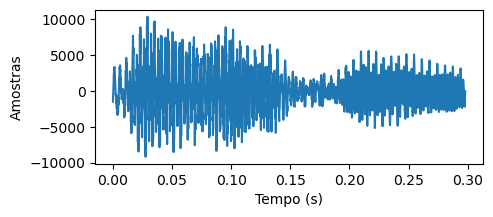

In [6]:
# Plotando um arquivo de audio
fs = 8*10**3 # 8 kHz sample rate (fonte: https://github.com/Jakobovski/free-spoken-digit-dataset)
t = np.arange(len(y))/fs
plt.figure(figsize=(5,2))
plt.plot(t,y)
plt.xlabel('Tempo (s)')
plt.ylabel('Amostras')
plt.show()

## Pré-processamento (transformar áudio em vetores)

AVISO: O DATASET É BAIXADO EM TEMPO DE EXECUÇÃO, ENTÃO A PRIMEIRA EXECUÇÃO DESTA CÉLULA DEVE LEVAR POR VOLTA DE 20min (depois, os dados ficam em cache e o acesso é mais rápido)

In [7]:
n_coef = 12
fs = 8000
X = np.zeros( (3000, 12) )
y = np.zeros( (3000, ))
speaker = []

for i in range(len(ds.audio)):
    x_ = ds.audio[i].numpy()
    x_.shape = (x_.shape[0],)
    
    # Normalização: transformar para média zero e variância 1
    x_ -= np.mean(x_)
    x_ /= np.std(x_)

    # Capturar MFCCs
    mfcc = librosa.feature.mfcc(y=x_, sr=fs, n_mfcc=n_coef, n_fft=512, hop_length=128)

    # Guardar média dos MFCCs
    # Se for usar mfccs diretamente (sem ser a média),
    # precisa tirar o cálculo da média
    # Dica: é para usar mfccs diretamente!
    # Dica 2: lembre-se de fazer zero-padding para deixar as observações todas com o mesmo tamanho
    # na dimensão do tempo, para poder usar o Keras
    X[i,:] = np.mean(mfcc, axis=1)
    y[i] = ds.labels[i].numpy()
    speaker.append(ds.speakers[i].numpy())

In [8]:
X = np.array(X)
y = np.array(y)
y.shape = (y.shape[0],)
print(X.shape)

(3000, 12)


## Separação em treino e teste

In [27]:
# Separação em treino e teste evitando que um falante fique tanto no treino quanto no teste
gss  = GroupShuffleSplit(n_splits=1, train_size=.5, random_state=42)
for idx_train_, idx_test_ in gss.split(X, y, speaker):
    idx_train = idx_train_
    idx_test = idx_test_
    
X_train = X[idx_train,:]
X_test = X[idx_test,:]
y_train = y[idx_train]
y_test = y[idx_test]


## Pipeline do classificador (baseline!)

In [28]:

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.37      0.28      0.32       150
         1.0       0.47      0.55      0.50       150
         2.0       0.24      0.67      0.35       150
         3.0       0.30      0.11      0.16       150
         4.0       0.60      0.70      0.64       150
         5.0       0.77      0.47      0.59       150
         6.0       0.25      0.12      0.16       150
         7.0       0.69      0.49      0.57       150
         8.0       0.79      0.63      0.70       150
         9.0       0.45      0.49      0.47       150

    accuracy                           0.45      1500
   macro avg       0.49      0.45      0.45      1500
weighted avg       0.49      0.45      0.45      1500

